## Austin Bike Sharing

Austin Bike sharing came out to be an interesting problem when my team was looking out for something that will have a higher level impact on our daily life in Austin.The value of this problem comes from the fact that it seeks to find a potential solution to a problem that has been plaguing Austin for years and will only continue to get worse: Traffic. This problem is most certainly applicable to not only the broad audience of citizens of Travis County, but can also be extended to other large metropolitan areas that suffer from similar traffic congestion, such as: Los Angeles, New York City, Atlanta, and
may more. There are also broader benefits of a solution that extend beyond traffic like health benefits and reduced pollution.

## Approach
The entire analysis is divided into three parts mainly  

1.Exploratory Data analysis  
2.Inference about the traffic using descriptive analysis and visualizations  
3.Recommendations  

In [42]:
from datetime import *
from gmplot import gmplot
import pandas as pd
%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

# Importing the data sets
stations = pd.read_csv("austin_bikeshare_stations.csv")
trips = pd.read_csv("austin_bikeshare_trips.csv")
weather=pd.read_csv('austin_weather.csv').drop(['DewPointHighF','DewPointLowF','HumidityHighPercent','HumidityLowPercent',
                                               'SeaLevelPressureHighInches','SeaLevelPressureLowInches','VisibilityHighMiles',
                                               'VisibilityLowMiles','WindHighMPH','WindGustMPH','HumidityAvgPercent'],1)

trips[:5]

Populating the interactive namespace from numpy and matplotlib


,bikeid,checkout_time,duration_minutes,end_station_id,end_station_name,month,start_station_id,start_station_name,start_time,subscriber_type,trip_id,year
0,8.0,19:12:00,41,2565.0,Trinity & 6th Street,3.0,2536.0,Waller & 6th St.,2015-03-19 19:12:00,Walk Up,9900082882,2015.0
1,141.0,2:06:04,6,2570.0,South Congress & Academy,10.0,2494.0,2nd & Congress,2016-10-30 02:06:04,Local365,12617682,2016.0
2,578.0,16:28:27,13,2498.0,Convention Center / 4th St. @ MetroRail,3.0,2538.0,Bullock Museum @ Congress & MLK,2016-03-11 16:28:27,Local365,9075366,2016.0
3,555.0,15:12:00,80,2712.0,Toomey Rd @ South Lamar,11.0,2497.0,Capitol Station / Congress & 11th,2014-11-23 15:12:00,24-Hour Kiosk (Austin B-cycle),9900319298,2014.0
4,86.0,15:39:13,25,3377.0,MoPac Pedestrian Bridge @ Veterans Drive,4.0,2707.0,Rainey St @ Cummings,2017-04-16 15:39:13,Walk Up,14468597,2017.0


## 1.Exploratory Data analysis  

Let's look at the data under 5 different cuts and carry the analysis forward in a step by step manner.  

Following are the different cuts at which we will be looking at the data.  
i.Location  
ii.Membership    
iii.Time  
iv.Weather  
v.Demographics  

Analysis at each step will help us uncover more patterns in Ausin Bike sharing  

### i. Location

What are the busiest stations during 2016?  
This will help in understanding the usage of bikes across stations

In [43]:
#Removing na if any in the dataset
trips = trips.dropna()

trips["start_time"] = trips["start_time"].map(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
trips["hours"] = trips["start_time"].map(lambda x : x.hour)
trips["weekday"] = trips["start_time"].map(lambda x : x.isoweekday())
trips['year1'] = trips['year'].apply(lambda x : str(int(x)))

Text(0.5,1,'Busiest stations in 2016')

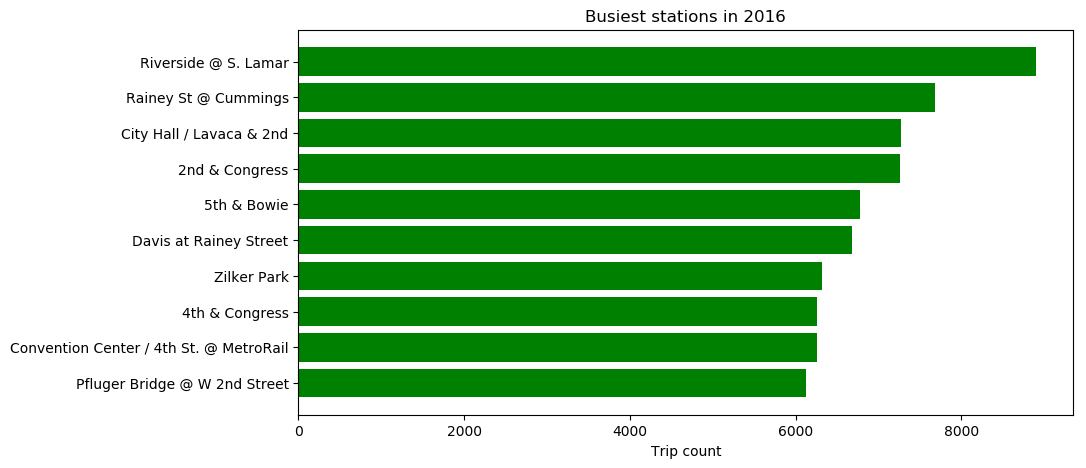

In [44]:
# Lets consider data from 2014,2015,2016 as those years contain data for all the months. 
# This will help us assess the seasonality without much trouble.

data_subset_years = trips[trips['year1'].isin(['2014','2015','2016'])]
busiest_stations = pd.DataFrame(data_subset_years.groupby(['year1','start_station_id','start_station_name'])['trip_id'].count().reset_index()).\
                                                                                    sort_values(by = 'trip_id',ascending= False)

busiest_stations_2016_top10 = busiest_stations[busiest_stations['year1'] == '2016'][:10]

plt.rcdefaults()
fig,(ax1) = subplots(nrows=1,
                           ncols=1,
                           sharey=False,
                           figsize=(10, 5))

ax1.barh(busiest_stations_2016_top10['start_station_name'],busiest_stations_2016_top10['trip_id'], align='center',
        color='green', ecolor='black')
ax1.set_yticks(busiest_stations_2016_top10['start_station_name'])
ax1.set_yticklabels(busiest_stations_2016_top10['start_station_name'])
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_xlabel('Station name')
ax1.set_xlabel('Trip count')
ax1.set_title('Busiest stations in 2016')

### ii. Membership
**What are the top 5 popular memberships?**

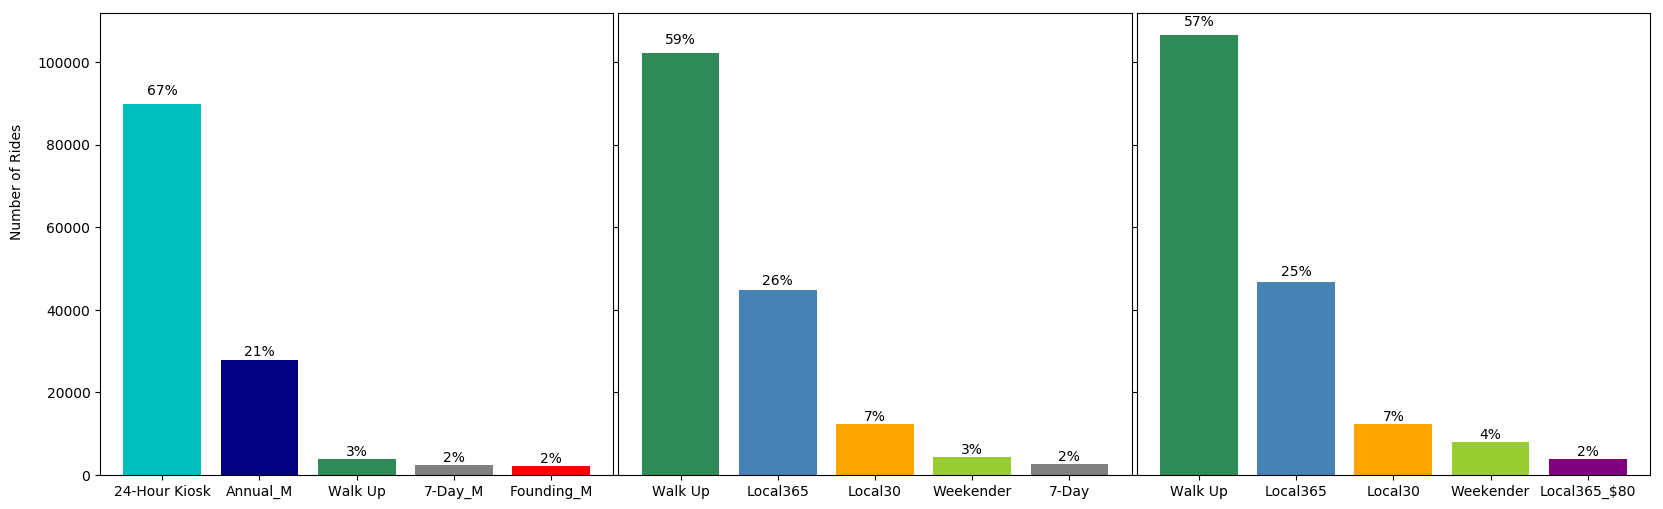

In [50]:
freq_m_year = trips.groupby(["year", "subscriber_type"])["subscriber_type"].count()

s_2014 = pd.Series(freq_m_year.loc[2014.0].sort_values(ascending = False)[:5])
s_2015  = pd.Series(freq_m_year.loc[2015.0].sort_values(ascending = False)[:5])
s_2016  = pd.Series(freq_m_year.loc[2016.0].sort_values(ascending = False)[:5])
s_sum = [sum(freq_m_year.loc[2014.0]), sum(freq_m_year.loc[2015.0]), sum(freq_m_year.loc[2016.0])]

s_2014.index = ["24-Hour Kiosk", "Annual_M", "Walk Up", "7-Day_M", "Founding_M"]
s_2016.index = ["Walk Up", "Local365", "Local30", "Weekender", "Local365_$80"]

def autolabel(ax, rects, year_sum):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        percentage = str(int(round(height/float(year_sum),2) *100)) + "%"
        ax.text(rect.get_x() + rect.get_width()/2., 1.015*height,
                 percentage,
                ha='center', va='bottom')


cc_2014 = ["c", "navy", "seagreen", "grey", "red"]
cc_2015 = ["seagreen","steelblue" ,"orange" , "yellowgreen", "grey"]
cc_2016 = ["seagreen", "steelblue","orange" , "yellowgreen", "purple"]

fig, (ax1, ax2, ax3) = subplots(nrows=1,
                                ncols=3,
                                sharey=True,
                                figsize=(20, 6))
fig.text(0.08, 0.6,"Number of Rides", va='center', rotation='vertical')
p1 = ax1.bar(s_2014.index.values, s_2014, color = cc_2014)
p2 = ax2.bar(s_2015.index.values, s_2015, color = cc_2015)
p3 = ax3.bar(s_2016.index.values, s_2016, color = cc_2016)
plt.subplots_adjust(wspace =0.01, hspace =0)
autolabel(ax1, p1, s_sum[0])
autolabel(ax2, p2, s_sum[1])
autolabel(ax3, p3, s_sum[2])

#savefig("membersplot.png")

The top 5 popular types of membership accounts for more than 95% of the Austin B-Cycle bike trips

From the bar plot, we know that around 60% of bike trips are contributed by ad-hoc useres. Moreover, trips taken by loclas, who owns a longer membership, shows a growing trend to more than 30%. Expecting the need of bike may be different between these two groups of members, this barplot helps us understand the composition of different type of needs.

## iii.Time

### What is the distribution of bike trips taken in each month of a year

In [10]:
active_groups_s = [ "Walk Up","Local365", "Local30", "Weekender",  "Explorer"]
end = datetime.datetime.strptime("2017", "%Y")
start = datetime.datetime.strptime("2014", "%Y")
trips_t_control = trips[(trips["start_time"] > start) & (trips["start_time"] < end)]
active_groups_mask = trips_t_control["subscriber_type"].map(lambda x : x in active_groups_s)

frequent_m_month = trips_t_control[active_groups_mask].groupby(["subscriber_type", "month"])["subscriber_type"].count()

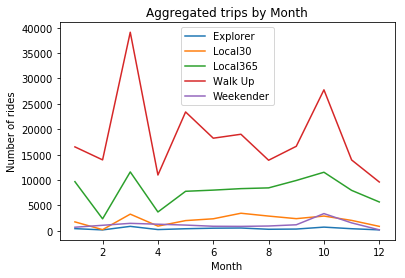

In [11]:
plot (frequent_m_month.loc["Explorer"], marker='None', linestyle='-', label='Explorer')
plot (frequent_m_month.loc["Local30"], marker='None', linestyle='-', label='Local30')
plot (frequent_m_month.loc["Local365"], marker='None', linestyle='-', label='Local365')
plot (frequent_m_month.loc["Walk Up"], marker='None', linestyle='-', label='Walk Up')
plot (frequent_m_month.loc["Weekender"], marker='None', linestyle='-', label='Weekender')
xlabel('Month')
ylabel('Number of rides')
title("Aggregated trips by Month")
legend(loc='best')
show()

We can see that summer is the season having more bike rides. It is noteworthy that there is two spikes of bike rentals in March and October, which are months that South by South West (SXSW) and Austin City Limit (ACL) are held in Austin, Texas.

### What if we plot the trips by week? What happens in weeks SXSW and ACL are held?

In [12]:
def plot_lines(df, subplots, title, xlabel, ylabel):
   '''Generates one or more line plots from pandas dataframe'''

   fig, ax = subplots
   ax = df.plot.line(ax=ax)
   ax.set_xlabel(xlabel, fontdict={'size' : 14})
   ax.set_ylabel(ylabel, fontdict={'size' : 14})
   ax.set_title(title, fontdict={'size' : 18})
   ttl = ax.title
   ttl.set_position([.5, 1.02])
   ax.tick_params(axis='x', labelsize=14)
   ax.tick_params(axis='y', labelsize=14)


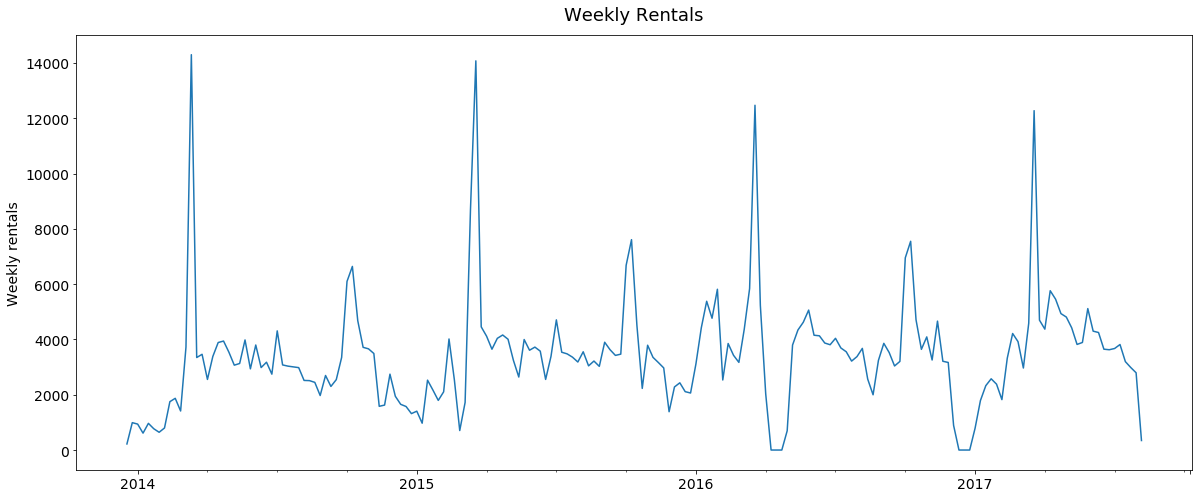

In [13]:
plot_week_df = trips.set_index("start_time")
plot_week_df.resample('W').size().head()
plot_lines(plot_week_df.resample('W').size(), plt.subplots(1,1, figsize=(20,8)),
              title='Weekly Rentals', xlabel='', ylabel='Weekly rentals')
#savefig("WeeklyRentalplot.png")

The weekly plot trend confirms that the spike in March and October are caused by SXSW and ACL.

### Does each day of a week has the same number of bike rides?


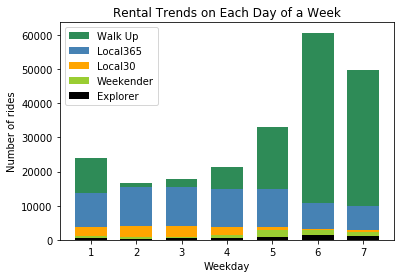

In [14]:
fig, ax = plt.subplots()
active_groups_s
frequent_m_weekday = trips_t_control[active_groups_mask].groupby(["subscriber_type", "weekday"])["subscriber_type"].count()
cc= ["seagreen", "steelblue" , "orange","yellowgreen", "black",]
for i in range(len(active_groups_s)):
    ax.bar( frequent_m_weekday.loc[active_groups_s[i]].index.values, 
            frequent_m_weekday.loc[active_groups_s[i]] , 
                                0.7, color = cc[i] , label = active_groups_s[i])

title("Rental Trends on Each Day of a Week")
ylabel('Number of rides')
xlabel("Weekday")
legend()
#savefig("BarplotByWeek.png")

From the plot below we can see that "Local 365" and "Loacal 30" have higher bike usage rate in the weekdays, while walk up members have more bike rentals on weekends.

### Plots on bike rental trends in a day

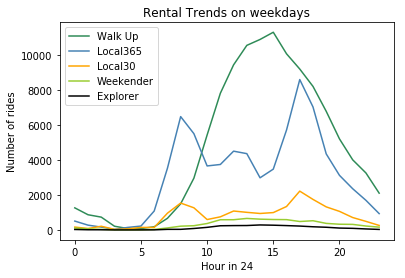

In [15]:
frequent_m_hour = trips_t_control[active_groups_mask & (trips_t_control["weekday"] <6)].groupby(["subscriber_type", "hours"])["subscriber_type"].count()
plot (frequent_m_hour.loc["Walk Up"], marker='None', linestyle='-', label='Walk Up', color = "seagreen")
plot (frequent_m_hour.loc["Local365"], marker='None', linestyle='-', label='Local365', color = "steelblue")
plot (frequent_m_hour.loc["Local30"], marker='None', linestyle='-', label='Local30', color = "orange")
plot (frequent_m_hour.loc["Weekender"], marker='None', linestyle='-', label='Weekender', color = "yellowgreen")
plot (frequent_m_hour.loc["Explorer"], marker='None', linestyle='-', label='Explorer', color = "black")

xlabel('Hour in 24')
ylabel('Number of rides')
title("Rental Trends on weekdays")
legend(loc='best')
#savefig("Daily_Rental_Trend(Weekdays).png")
show()

In weekdays, local members tend to have higher bike usage during rush hours. In contrast, explorer's bike rental are more spreadout through the whole day.

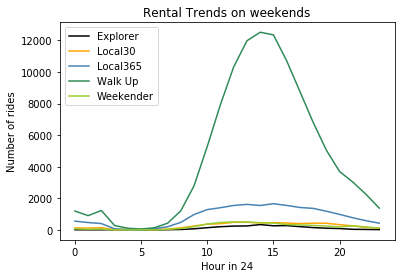

In [16]:
frequent_m_hour = trips_t_control[active_groups_mask & (trips_t_control["weekday"] >= 6)].groupby(["subscriber_type", "hours"])["subscriber_type"].count()
plot (frequent_m_hour.loc["Explorer"], marker='None', linestyle='-', label='Explorer', color = "black")
plot (frequent_m_hour.loc["Local30"], marker='None', linestyle='-', label='Local30', color = "orange")
plot (frequent_m_hour.loc["Local365"], marker='None', linestyle='-', label='Local365', color = "steelblue")
plot (frequent_m_hour.loc["Walk Up"], marker='None', linestyle='-', label='Walk Up', color = "seagreen")
plot (frequent_m_hour.loc["Weekender"], marker='None', linestyle='-', label='Weekender', color = "yellowgreen")
xlabel('Hour in 24')
ylabel('Number of rides')
title("Rental Trends on weekends")
legend(loc='best')
#savefig("Daily_Rental_Trend(Weekends).png")
show()

On weekends, most bikes are rented in daytime and have no peak in rush hours.

### Bike rents on the big events
Since SXSW and ACL has generated an high demand in bike trips, we worked futher on ploting the trips in these festival to understand the demand pattern and whether such demand had skewed plots we drew to see daily patterns.


### South by South West

In [17]:
SXSW_start_2014 = datetime.datetime(2014, 3, 7, 0, 0, 0)
SXSW_end_2014 = datetime.datetime(2014, 3, 14, 23, 59, 59)
SXSW_start_2015 = datetime.datetime(2015, 3, 13, 0, 0, 0)
SXSW_end_2015 = datetime.datetime(2015, 3, 23, 23, 59, 59)
SXSW_start_2016 = datetime.datetime(2016, 3, 11, 0, 0, 0)
SXSW_end_2016 = datetime.datetime(2016, 3, 20, 23, 59, 59)

In [18]:
SXSW_mask = ((trips_t_control["start_time"] > SXSW_start_2014) & (trips_t_control["start_time"] < SXSW_end_2014)) | \
                   ((trips_t_control["start_time"] > SXSW_start_2015) & (trips_t_control["start_time"] < SXSW_end_2015)) | \
                  ((trips_t_control["start_time"] > SXSW_start_2016) & (trips_t_control["start_time"] < SXSW_end_2016))

In [19]:
trips_SXSW = trips_t_control[SXSW_mask]
SXSW_weekend_hour = trips_SXSW[(trips_SXSW["weekday"] >= 6)].groupby(["year"])["year"].count()
SXSW_weekday_hour = trips_SXSW[ (trips_SXSW["weekday"] < 6)].groupby(["year"])["year"].count()

In [20]:
SXSW_weekend_hour.values

array([1878, 7780, 6556], dtype=int64)

In [21]:
SXSW_weekend_hour.index = [str(int(i)) for i in SXSW_weekend_hour.index.values]
SXSW_weekday_hour.index = [str(int(i)) for i in SXSW_weekday_hour.index.values]

In [22]:
SXSW_plot_df = pd.DataFrame({"Weekends": SXSW_weekend_hour.values, "Weekdays" : SXSW_weekday_hour.values}, 
                            index = [2014, 2015, 2016] )

SXSW_plot_df["Weekdays"] = SXSW_plot_df["Weekdays"]/5
SXSW_plot_df["Weekends"] = SXSW_plot_df["Weekends"]/2

From the plot bellow, I plotted the comparision of daily bike rent between weekdays and weekends. Generally, SXSW has a balanced bike rental demand between weekdays and weekdens.

Text(0.5,1,'SXSW weekdays V.S. weekend plot')

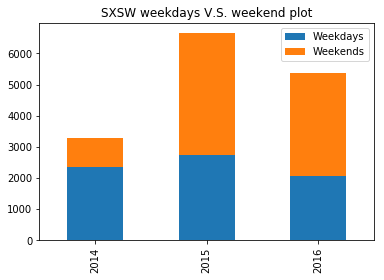

In [23]:
SXSW_plot_df.plot.bar(stacked=True)
title("SXSW weekdays V.S. weekend plot")
#savefig("plots_local/SXSW_weekday2weekend_regularized_by_day.png")

Most trips in SXSW are taken in the morning.

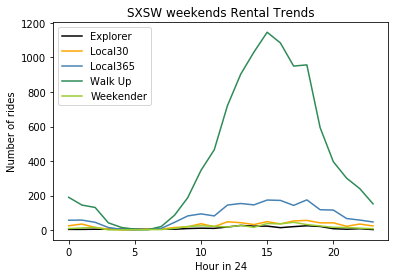

In [24]:
SXSW_hour = trips_SXSW[(trips_SXSW["weekday"] >= 6)].groupby([ "subscriber_type", "hours"])[["hours"]].count()

plot (SXSW_hour.loc["Explorer"], marker='None', linestyle='-', label='Explorer', color = "black")
plot (SXSW_hour.loc["Local30"], marker='None', linestyle='-', label='Local30', color = "orange")
plot (SXSW_hour.loc["Local365"], marker='None', linestyle='-', label='Local365', color = "steelblue")
plot (SXSW_hour.loc["Walk Up"], marker='None', linestyle='-', label='Walk Up', color = "seagreen")
plot (SXSW_hour.loc["Weekender"], marker='None', linestyle='-', label='Weekender', color = "yellowgreen")
xlabel('Hour in 24')
ylabel('Number of rides')
title("SXSW weekends Rental Trends")
legend(loc='best')
#savefig("SXSW weekends Rental Trends.png")
show()

### Austin City Limit

In [25]:
ACL_start_2014_W1 = datetime.datetime(2014, 10, 3, 0, 0, 0)
ACL_end_2014_W1 = datetime.datetime(2014, 10, 5, 23, 59, 59)
ACL_start_2014_W2 = datetime.datetime(2014, 10, 10, 0, 0, 0)
ACL_end_2014_W2 = datetime.datetime(2014, 10, 12, 23, 59, 59)
ACL_start_2015_W1 = datetime.datetime(2015, 10, 2, 0, 0, 0)
ACL_end_2015_W1 = datetime.datetime(2015, 10, 4, 23, 59, 59)
ACL_start_2015_W2 = datetime.datetime(2015, 10, 9, 0, 0, 0)
ACL_end_2015_W2 = datetime.datetime(2015, 10, 11, 23, 59, 59)
ACL_start_2016_W1 = datetime.datetime(2016, 9, 30, 0, 0, 0)
ACL_end_2016_W1 = datetime.datetime(2016, 10, 2, 23, 59, 59)
ACL_start_2016_W2 = datetime.datetime(2016, 10, 7, 0, 0, 0)
ACL_end_2016_W2 = datetime.datetime(2016, 10, 9, 23, 59, 59)

In [26]:
ACL_mask = ((trips_t_control["start_time"] > ACL_start_2014_W1) & (trips_t_control["start_time"] < ACL_end_2014_W1)) | \
                  ((trips_t_control["start_time"] > ACL_start_2014_W2) & (trips_t_control["start_time"] < ACL_end_2014_W2)) | \
                   ((trips_t_control["start_time"] > ACL_start_2015_W1) & (trips["start_time"] < ACL_end_2015_W1)) | \
                  (trips_t_control["start_time"] > ACL_start_2015_W2) & (trips_t_control["start_time"] < ACL_end_2015_W2) | \
                 ((trips_t_control["start_time"] > ACL_start_2016_W1) & (trips_t_control["start_time"] < ACL_end_2016_W1)) | \
                ((trips_t_control["start_time"] > ACL_start_2016_W2) & (trips_t_control["start_time"] < ACL_end_2016_W2))

In [27]:
trips_ACL = trips_t_control[ACL_mask]
ACL_hour = trips_ACL[trips_ACL["weekday"] >= 6].groupby(["subscriber_type", "hours"])["subscriber_type"].count()
ACL_weekend_hour = trips_ACL[(trips_ACL["weekday"] >= 6)].groupby(["year"])["year"].count()

C:\Users\Akhil\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


While ACL is a weekend event, we can only compare the difference of rental across three years. We can see a growing trend of bike demand.

Text(0.5,1,'ACL weekend')

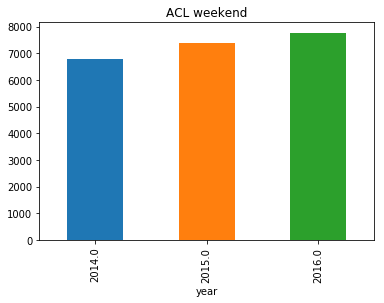

In [28]:
ACL_weekend_hour.plot(kind = "bar")
title("ACL weekend")
#savefig("plots_local/ACLweekend.png")

Compared to SXSW, ACL ends later at night, so there is a spike around 10 pm for people leaving from ACL.

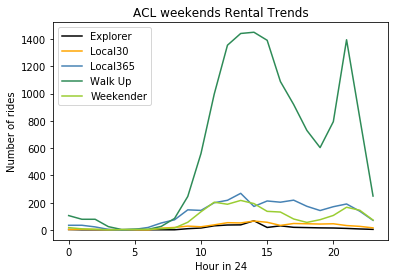

In [29]:
ACL_hour = trips_ACL.groupby([ "subscriber_type", "hours"])[["hours"]].count()

plot (ACL_hour.loc["Explorer"], marker='None', linestyle='-', label='Explorer', color = "black")
plot (ACL_hour.loc["Local30"], marker='None', linestyle='-', label='Local30', color = "orange")
plot (ACL_hour.loc["Local365"], marker='None', linestyle='-', label='Local365', color = "steelblue")
plot (ACL_hour.loc["Walk Up"], marker='None', linestyle='-', label='Walk Up', color = "seagreen")
plot (ACL_hour.loc["Weekender"], marker='None', linestyle='-', label='Weekender', color = "yellowgreen")
xlabel('Hour in 24')
ylabel('Number of rides')
title("ACL weekends Rental Trends")
legend(loc='best')
#savefig("ACL weekends Rental Trends.png")
show()

### Barchart by day of a week taking out SXSW and ACL trips
After taking out SXSW and ACL bike rental, we observed no difference in numbers of bike rental in a week.

In [30]:
trips_exclude_events = trips_t_control[ (~ACL_mask) & (~SXSW_mask)]
trips_excluded_weekdays = trips_exclude_events[active_groups_mask].groupby(["subscriber_type", "weekday"])["subscriber_type"].count()
trips_excluded_weekdays[:10]


C:\Users\Akhil\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\Akhil\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


subscriber_type  weekday
Explorer         1           573
                 2           287
                 3           362
                 4           415
                 5           698
                 6          1186
                 7           768
Local30          1          3361
                 2          3733
                 3          3711
Name: subscriber_type, dtype: int64

Text(0.5,1,'Rental Trends on Each Day Excluding ACL and SXSW')

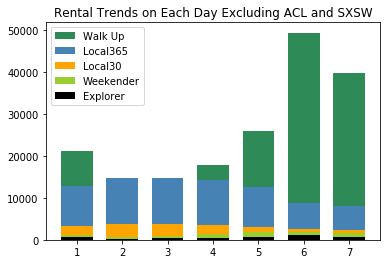

In [31]:
fig, ax = plt.subplots()

cc= ["seagreen", "steelblue" , "orange","yellowgreen", "black",]
for i in range(len(active_groups_s)):
    ax.bar( trips_excluded_weekdays.loc[active_groups_s[i]].index.values, 
            trips_excluded_weekdays.loc[active_groups_s[i]] , 
                                0.7, color = cc[i] , label = active_groups_s[i])

legend()
title("Rental Trends on Each Day Excluding ACL and SXSW")
#savefig("plots_local/Rental Trends on Each Day Excluding ACL and SXSW")

## iv. Weather

In [51]:
weather.head()

,Date,TempHighF,TempAvgF,TempLowF,DewPointAvgF,SeaLevelPressureAvgInches,VisibilityAvgMiles,WindAvgMPH,PrecipitationSumInches,Events
0,2013-12-21,74,60,45,49,29.68,7,4,0.46,"Rain , Thunderstorm"
1,2013-12-22,56,48,39,36,30.13,10,6,0,
2,2013-12-23,58,45,32,27,30.49,10,3,0,
3,2013-12-24,61,46,31,28,30.45,10,4,0,
4,2013-12-25,58,50,41,40,30.33,10,2,T,


Data pre-processing:  
1. Setting flag for rain  
2. Setting Date as index

In [52]:
weather.Events.unique()
weather['Rain']=np.where(weather.Events.str.contains('Rain'), 1, 0)
weather.Date=pd.to_datetime(weather.Date)
weather=weather.set_index('Date').drop('Events',1)

#### Monthly Temperature

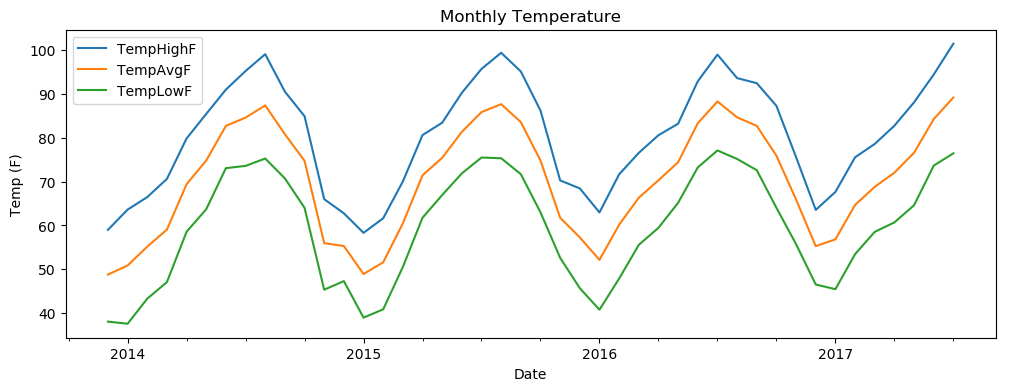

In [53]:
weather[['TempHighF', 'TempAvgF', 'TempLowF']].resample('M').mean().plot(title='Monthly Temperature', figsize=(12,4))
plt.ylabel('Temp (F)')
plt.show()

#### Monthly precipitation

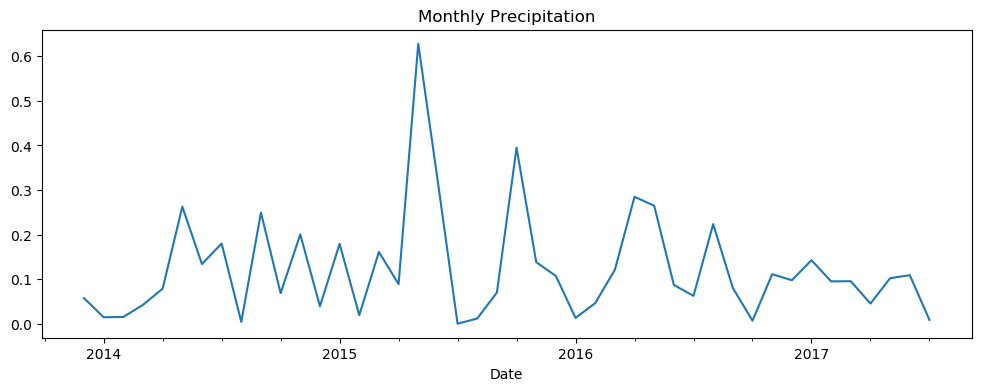

In [54]:
weather['PrecipitationSumInches']=pd.to_numeric(weather['PrecipitationSumInches'],errors='coerce')
weather['PrecipitationSumInches'].resample('M').mean().plot(title='Monthly Precipitation', figsize=(12, 4))
plt.show()

#### Monthly wind

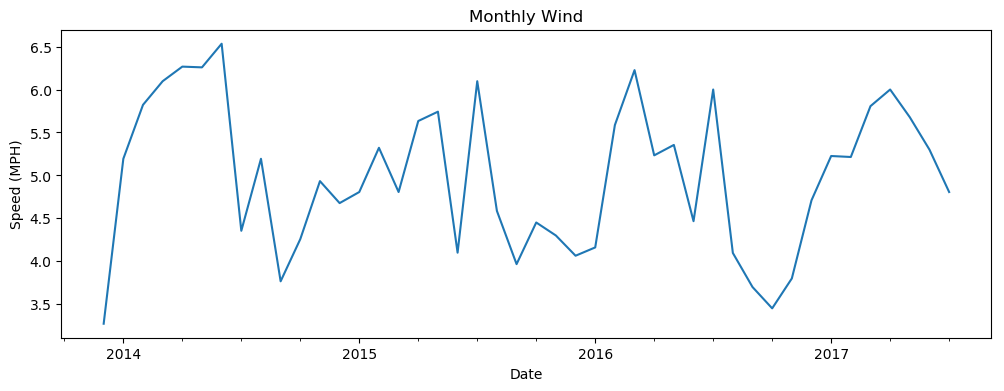

In [55]:
weather['WindAvgMPH']=pd.to_numeric(weather['WindAvgMPH'],errors='coerce')
weather['WindAvgMPH'].resample('M').mean().plot(title='Monthly Wind', figsize=(12,4))
plt.ylabel('Speed (MPH)')
plt.show()

### Impact of weather on bike sharing during different seasons

#### Rainy season
** ~67% decrease of people who ride bikes in rainy days**

In [57]:
ind = pd.DatetimeIndex(trips.start_time)
trips['Date'] = ind.date.astype('datetime64')
trips['hour'] = ind.hour
by_date = trips.pivot_table('trip_id', aggfunc='count',index='Date',columns='subscriber_type', )
by_date = trips.groupby(['Date', 'subscriber_type'])['trip_id'].count()
by_date.name = 'count'
by_date = by_date.reset_index('subscriber_type')
trips_2=trips[trips.year.isin([2014,2015,2016])]
trip_weather=trips_2.merge(weather,left_on='Date',right_on='Date',
                         suffixes=['_trips','_weather']).drop(['SeaLevelPressureAvgInches'],1)
trip_weather=trip_weather.drop(['DewPointAvgF','VisibilityAvgMiles','end_station_id','end_station_name','bikeid',
                                'TempHighF','TempLowF'],1)

rainy=trip_weather.groupby('Rain')['trip_id'].count()
rainy['percentage drop']=(rainy[0]-rainy[1])/float(rainy[0])
rainy


Rain
0                  370034.000000
1                  120123.000000
percentage drop         0.675373
Name: trip_id, dtype: float64

#### Effect of rain on different stations

In [59]:
rain_station=trip_weather.groupby(['start_station_name','Rain'])['trip_id'].count().unstack()
rain_station['percentage drop']=(rain_station[0]-rain_station[1])/rain_station[0]
rain_station[rain_station[0]>=1000].sort_values(0,ascending=False).head(20)

Rain,0,1,percentage drop
start_station_name,,,
City Hall / Lavaca & 2nd,17603.0,5578.0,0.683122
Riverside @ S. Lamar,16883.0,4913.0,0.708997
5th & Bowie,16622.0,5003.0,0.699013
2nd & Congress,15849.0,4937.0,0.688498
4th & Congress,15103.0,5112.0,0.661524
Convention Center / 4th St. @ MetroRail,14257.0,5360.0,0.624044
Rainey St @ Cummings,13425.0,4273.0,0.681713
Capitol Station / Congress & 11th,12472.0,3948.0,0.683451
Davis at Rainey Street,12383.0,4494.0,0.637083


#### Summer and winter
** ~36% drop in hot days and 71% drop in cold days since Austin people are more used to the high tempearture**

In [60]:
trip_weather['Temp']='Medium Temp'
trip_weather.loc[trip_weather['TempAvgF']>=80,'Temp']='High Temp'
trip_weather.loc[trip_weather['TempAvgF']<=59,'Temp']='Low Temp'

temperature=trip_weather.groupby('Temp')['trip_id'].count()
temperature['percent drop in hot days']=(temperature['Medium Temp']-temperature['High Temp'])/float(temperature['Medium Temp'])
temperature['percent drop in cold days']=(temperature['Medium Temp']-temperature['Low Temp'])/float(temperature['Medium Temp'])
temperature


Temp
High Temp                    162116.000000
Low Temp                      72456.000000
Medium Temp                  255585.000000
percent drop in hot days          0.365706
percent drop in cold days         0.716509
Name: trip_id, dtype: float64

## Insights:
* The Walk up membership accounts over 60% of the rides. Most of the rides taken are on weekends and are more on a ad-hoc base.
* 24 - hour kiosks is the most popular bike sharing plan  
* Bike sharing traffic is high between 9 AM and 8 PM as expected  
* During ACL, there are peaks in the morning at 11 AM due to people going to ACL and at 10 PM due to people coming back from ACL   
* Different weather conditions affect bike sharing in different ways
    During Rainy season, there is 67% drop in bike sharing on average  
    During Summer, there is 36% drop in bike sharing on average  
    During Winter, there is 72% drop in bike sharing on average  
* The locals are renting more bikes on weekdays, which causes the bike rebalancing problem during rush hours.
* The above results has taken the spike of trips during SXSW and ACL into consideration.